This notebook is primary geared towards looking at the algorithm output.

In particular, since the compute job was stopped due to Cheyenne maintenance, I save intermediate $w$, $c$, and $\lambda$ vectors to `./data/results/00/...`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy import stats
from scipy.optimize import minimize

In [2]:
from generate_opt_objects import A_b_generation

In [3]:
# results base directory
BASE_DIR = './data/carbon_flux/results'

# Look at $w$ optimization trajectory

In [4]:
# read in the raw stdout file
with open(BASE_DIR + '/02/stdout.txt', 'r') as f:
    stdout_raw = f.readlines()

# standard out starting from iteration 2
with open(BASE_DIR + '/02/stdout_from_it2.txt', 'r') as f:
    stdout_raw_it2 = f.readlines()

In [5]:
# isolate the trajectories from the second w optimization
all_obj_vals = [float(line[22:34].replace('D', 'e')) for line in stdout_raw if 'At iterate' in line]
traj_w_01 = all_obj_vals[:13]
traj_c_01 = all_obj_vals[13:17]
traj_w_02 = all_obj_vals[17:30]
traj_c_02 = all_obj_vals[30:]

print(traj_c_01[0])
print(traj_w_02[0])
print(traj_c_02[0])

406762.0
-274785.0
-532205.0


In [7]:
all_obj_vals_it2 = [
    float(line[22:34].replace('D', 'e')) for line in stdout_raw_it2 if 'At iterate' in line
]

traj_w_03 = all_obj_vals_it2[:3]
traj_c_03 = all_obj_vals_it2[3:6]
traj_w_04 = all_obj_vals_it2[6:11]
traj_c_04 = all_obj_vals_it2[11:14]
traj_w_05 = all_obj_vals_it2[14:]
# traj_c_05 = all_obj_vals_it2[:]

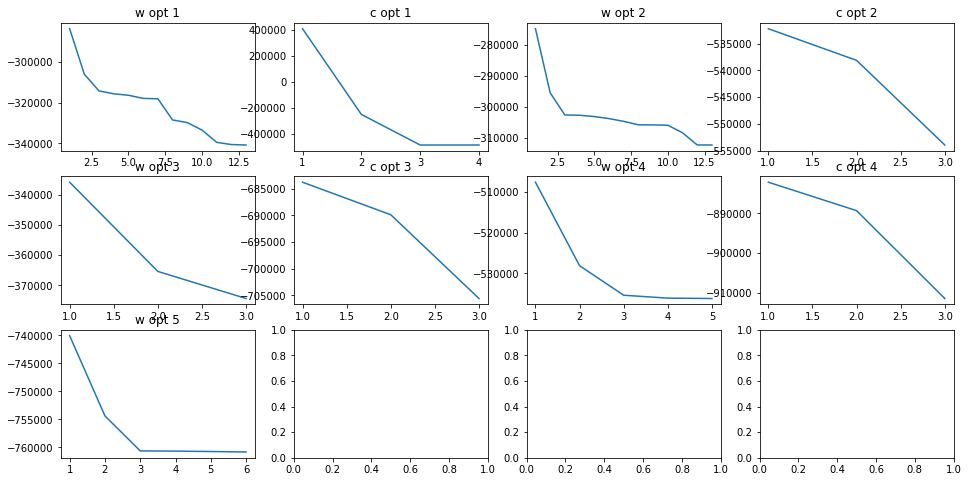

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))

# plots

# iteration 0
ax[0, 0].plot(np.arange(1, 14), traj_w_01)
ax[0, 1].plot(np.arange(1, 5), traj_c_01)

# iteration 1
ax[0, 2].plot(np.arange(1, 14), traj_w_02)
ax[0, 3].plot(np.arange(1, 4), traj_c_02)

# iteration 2
ax[1, 0].plot(np.arange(1, 4), traj_w_03)
ax[1, 1].plot(np.arange(1, 4), traj_c_03)

# iteration 4
ax[1, 2].plot(np.arange(1, len(traj_w_04) + 1), traj_w_04)
ax[1, 3].plot(np.arange(1, len(traj_c_04) + 1), traj_c_04)

# iteration 5
ax[2, 0].plot(np.arange(1, len(traj_w_05) + 1), traj_w_05)
# ax[2, 1].plot(np.arange(1, len(traj_c_04) + 1), traj_c_05)

# titles
ax[0, 0].set_title('w opt 1')
ax[0, 1].set_title('c opt 1')
ax[0, 2].set_title('w opt 2')
ax[0, 3].set_title('c opt 2')
ax[1, 0].set_title('w opt 3')
ax[1, 1].set_title('c opt 3')
ax[1, 2].set_title('w opt 4')
ax[1, 3].set_title('c opt 4')
ax[2, 0].set_title('w opt 5')

plt.show()

# Feasibility Condition

\begin{equation}
\lVert h + A^T c - K^T w \rVert_2^2
\end{equation}

In [17]:
# import h
with open('./data/carbon_flux/objects/na_june_functional.npy', 'rb') as f:
    h = np.load(f)

# import A
A, b = A_b_generation(
    box_constraint_fp='./data/carbon_flux/objects/scipy_bnds.pkl'
)

print(f'Dim of A: {A.shape}')
print(f'Dim of b: {b.shape}')

Dim of A: (11120, 26496)
Dim of b: (11120,)


#### Starting feasibility

In [18]:
# read in starting points
START_POINT_DIR = './data/carbon_flux/results/02/intermediate_starts/'

with open(START_POINT_DIR + '/cheyenne_stop_w_vec.npy', 'rb') as f:
    w_sp = np.load(f)
with open(START_POINT_DIR + '/cheyenne_stop_c_vec.npy', 'rb') as f:
    c_sp = np.load(f)

In [19]:
# read in K^T w for starting w
with open('../fixed_optimization_inputs/KTw_for_w_start.npy', 'rb') as f:
    KTw_0 = np.load(f)

In [20]:
np.linalg.norm(h + A.T @ c_sp - KTw_0)

16.994936714923163

#### Feasibilitiy after first iteration

In [21]:
# import results dictionary
with open(BASE_DIR + '/02/opt_output_01.pkl', 'rb') as f:
    res_dict = pickle.load(f)
    
print(list(res_dict.keys()))

['objective_evals', 'w_opt_vecs', 'c_opt_vecs', 'lambda_opt_vecs', 'KTw_vecs']


In [22]:
res_dict['objective_evals']

[-28976.74552516779, -33522.524430791666]

In [23]:
# extract plotting objects from results_dict
KTw_vecs = res_dict['KTw_vecs'].copy()
c_vecs = res_dict['c_opt_vecs'].copy()

# look at the norm of the constraint term
num_iters = KTw_vecs.shape[0]
print(f'Number of iterations: {num_iters}')

constr_mat = np.array([
    h + A.T @ c_vecs[i, :] - KTw_vecs[i, :]
    for i in range(num_iters)
])
feasibility = np.sqrt(np.diagonal(constr_mat @ constr_mat.T))

Number of iterations: 10


In [24]:
feasibility

array([10.97259036,  8.17085017,  0.17412791,  0.17412791,  0.17412791,
        0.17412791,  0.17412791,  0.17412791,  0.17412791,  0.17412791])

In [25]:
# import results dictionary
with open(BASE_DIR + '/02/opt_output_02.pkl', 'rb') as f:
    res_dict_02 = pickle.load(f)
    
print(list(res_dict_02.keys()))

['objective_evals', 'w_opt_vecs', 'c_opt_vecs', 'lambda_opt_vecs', 'KTw_vecs']


In [26]:
# extract plotting objects from results_dict
KTw_vecs = res_dict_02['KTw_vecs'].copy()
c_vecs = res_dict_02['c_opt_vecs'].copy()

# look at the norm of the constraint term
num_iters = KTw_vecs.shape[0]
print(f'Number of iterations: {num_iters}')

constr_mat = np.array([
    h + A.T @ c_vecs[i, :] - KTw_vecs[i, :]
    for i in range(num_iters)
])
feasibility = np.sqrt(np.diagonal(constr_mat @ constr_mat.T))

print(feasibility)

Number of iterations: 10
[0.17412791 0.17412791 6.33246292 0.17412791 0.17412791 0.17412791
 0.17412791 0.17412791 0.17412791 0.17412791]


In [27]:
# step 4
# import results dictionary
with open(BASE_DIR + '/02/opt_output_03.pkl', 'rb') as f:
    res_dict_03 = pickle.load(f)
    
print(list(res_dict_03.keys()))

# extract plotting objects from results_dict
KTw_vecs = res_dict_03['KTw_vecs'].copy()
c_vecs = res_dict_03['c_opt_vecs'].copy()

# look at the norm of the constraint term
num_iters = KTw_vecs.shape[0]
print(f'Number of iterations: {num_iters}')

constr_mat = np.array([
    h + A.T @ c_vecs[i, :] - KTw_vecs[i, :]
    for i in range(num_iters)
])
feasibility = np.sqrt(np.diagonal(constr_mat @ constr_mat.T))

print(feasibility)

['objective_evals', 'w_opt_vecs', 'c_opt_vecs', 'lambda_opt_vecs', 'KTw_vecs']
Number of iterations: 10
[0.17412791 0.17412791 6.33246292 5.55073525 0.17412791 0.17412791
 0.17412791 0.17412791 0.17412791 0.17412791]


In [28]:
# save the disparate feasibility values
feas_vals = [16.994936714923163, 10.97259036,  8.17085017, 6.33246292, 5.55073525]

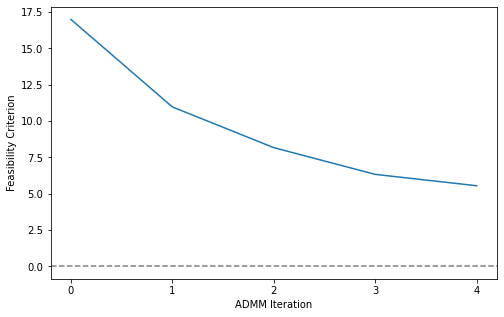

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(feas_vals)
plt.axhline(0, linestyle='--', color='gray')

plt.xticks(np.arange(len(feas_vals)))

plt.xlabel('ADMM Iteration')
plt.ylabel('Feasibility Criterion')

plt.show()

# Save new starting points

#### For ADMM iteration 2

In [41]:
# isolate the starting vectors
w_start_02 = res_dict['w_opt_vecs'][1, :].copy()
c_start_02 = res_dict['c_opt_vecs'][1, :].copy()
lambda_start_02 = res_dict['lambda_opt_vecs'][1, :].copy()

In [42]:
# output vectors
with open(BASE_DIR + '/02/intermediate_starts/w_start_it2.npy', 'wb') as f:
    np.save(file=f, arr=w_start_02)

with open(BASE_DIR + '/02/intermediate_starts/c_start_it2.npy', 'wb') as f:
    np.save(file=f, arr=c_start_02)

with open(BASE_DIR + '/02/intermediate_starts/lambda_start_it2.npy', 'wb') as f:
    np.save(file=f, arr=lambda_start_02)

#### For ADMM iteration 5

In [11]:
# read in the previous progress
with open(BASE_DIR + '/02/opt_output_04.pkl', 'rb') as f:
    res_dict_04 = pickle.load(f)

In [19]:
# save the new starting vectors
w_start_05 = res_dict_04['w_opt_vecs'][4, :].copy()
c_start_05 = res_dict_04['c_opt_vecs'][4, :].copy()
lambda_start_05 = res_dict_04['lambda_opt_vecs'][4, :].copy()

In [23]:
# output vectors
with open(BASE_DIR + '/02/intermediate_starts/w_start_it5.npy', 'wb') as f:
    np.save(file=f, arr=w_start_05)

with open(BASE_DIR + '/02/intermediate_starts/c_start_it5.npy', 'wb') as f:
    np.save(file=f, arr=c_start_05)

with open(BASE_DIR + '/02/intermediate_starts/lambda_start_it5.npy', 'wb') as f:
    np.save(file=f, arr=lambda_start_05)